In [2]:
import pandas as pd
import numpy as np
import torch
from einops import repeat

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import seaborn as sns

from posenc.datasets.chestx import ChestXDataModule
from posenc.nets.positional_encodings import PositionalEmbedding


sns.set_context("paper", font_scale=1.5)

# Figure 1

In [8]:
# # For generating the mean image the dataset must be downloaded. We simply load the saved mean image.
# # This is the code to generate the mean image
# chestx = ChestXDataModule(
#     task="binary", batch_size=128, num_workers=32, do_cutmix=False, do_mixup=False
# )
# chestx.setup()
# mean_image = torch.zeros(224, 224)
# for i in range(100):
#     for _ in range(5):
#         mean_image += chestx.valid[i][0][0]
# mean_image /= 500
# mean_image = mean_image.numpy()

# with open('../results/mean_chestx_image.npy', 'wb') as f:
#     np.save(f, mean_image)

# Load the mean image
mean_image = np.load("../results/mean_chestx_image.npy")

In [ ]:
def show_positional_similarity(grid_size, pos_embedding, idx, cosine=False):
    # Extract the query embedding and add a batch dimension
    query = pos_embedding[idx, :].unsqueeze(0)  # Shape: [1, embedding_dim]
    
    # Compute dot products between query and all embeddings
    similarity = torch.matmul(query, pos_embedding.T)  # Shape: [1, num_embeddings]

    if cosine:
        # Compute L2 norms for the query and each positional embedding
        query_norm = torch.norm(query, p=2, dim=1)  # Shape: [1]
        pos_norms = torch.norm(pos_embedding, p=2, dim=1)  # Shape: [num_embeddings]
        
        # Compute cosine similarities (dot product divided by product of norms)
        similarity = similarity / (query_norm * pos_norms)  # Shape: [1, num_embeddings]
    
    # Reshape to match grid dimensions and return
    return similarity.view(*grid_size)

# Get the 'Reds' colormap
base_cmap = get_cmap('magma')

# Define a function to modify the alpha channel
def modified_colormap(cmap, alpha_func):
    colors = cmap(np.linspace(0, 1, 256))  # Get the original colormap
    alphas = alpha_func(np.linspace(0, 1, 256))  # Alpha increases as values get smaller
    colors[:, -1] = alphas  # Modify the alpha channel
    return mcolors.ListedColormap(colors)

# Define the alpha function (linear scaling from 0 to 0.8)
def alpha_func(values):
    return 0.8 * values  # Ensures alpha is 0 at the smallest value and 0.8 at the largest

# Create the new colormap
custom_cmap = modified_colormap(base_cmap, alpha_func)

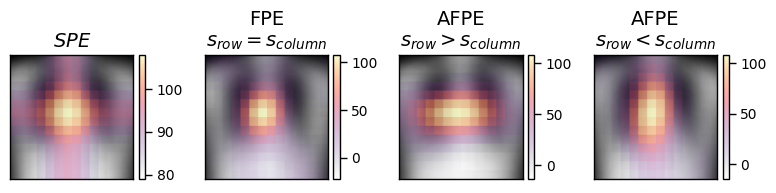

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(8, 2))

# Define settings for each subplot
configs = [
    ("sincos", None, "$SPE$", 90),
    ("isofpe", [1., 1.], "FPE\n${s_{row} = s_{column}}$", 90),
    ("isofpe", [1.125, 0.497], "AFPE\n${s_{row} > s_{column}}$", 90),
    ("isofpe", [0.497, 1.125], "AFPE\n${s_{row} < s_{column}}$", 90)
]

for ax, (method, variance_factors, title, index) in zip(axes, configs):
    # Generate positional embedding
    pembed = PositionalEmbedding(method, 224, 16, 216, 2, variance_factors=variance_factors)
    pembed = pembed.positions.clone().detach()[0]

    # Compute similarity
    sim = show_positional_similarity([14, 14], pembed, index)
    sim = repeat(sim, "h w -> (h r1) (w r2)", r1=16, r2=16)

    # Plot
    im1 = ax.imshow(mean_image, cmap="gray")
    im2 = ax.imshow(sim, cmap=custom_cmap)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set title
    ax.set_title(title, fontsize=14)

    # Add colorbar
    cbar = fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=10)

# Adjust layout
plt.tight_layout()
plt.savefig("../results/iso_pe_comparison_2d_chestx.eps", dpi=300)
plt.show()

# Figure 2

In [ ]:

def load_chestx_df(path="../results/chestx_isotropy.csv"):
    # Load dataframe
    df = pd.read_csv(path)
    
    # Basic filtering and dtype processing
    df = df[df.epoch == 49]
    df["Column Variance"] = df.variance_factors.apply(lambda x: eval(x)[1])
    df["Row Variance"] = df.variance_factors.apply(lambda x: eval(x)[0])
    df["Isotropy"] = df["Row Variance"] / df["Column Variance"]
    df = df.rename(columns=lambda x: x.split("/")[1] if len(x.split("/")) > 1 else x)
    
    # Melt the DataFrame
    id_vars = ["Name", 'variance_factors', 'epoch', 'Column Variance', 'Row Variance', 'Isotropy']
    df_melted = df.melt(id_vars=id_vars, var_name="metric_class", value_name="value")
    
    # Extract metric and class using regex
    df_melted[["metric", "class"]] = df_melted["metric_class"].str.extract(r"(\w+)_(.+)")
    
    # Compute F1
    _df_f1 = df_melted.loc[df_melted["metric"] == "precision"].reset_index().copy()
    
    f1 = (2 * df_melted.loc[df_melted["metric"] == "precision", "value"].values * df_melted.loc[df_melted["metric"] == "recall", "value"].values / (
        df_melted.loc[df_melted["metric"] == "precision", "value"].values + df_melted.loc[df_melted["metric"] == "recall", "value"].values
    ))
    _df_f1["metric"] = "f1"
    _df_f1["value"] = f1
    
    max_values = _df_f1.groupby("class")["value"].max().dropna().reset_index()
    
    # Get corresponding isotropy values
    isotropy_values = _df_f1.loc[_df_f1.groupby("class")["value"].idxmax().dropna(), ["class", "Isotropy"]]
    
    # Merge max values and isotropy values
    plot_df = max_values.merge(isotropy_values, on="class")

    # Separate the mean class for special styling
    mean_point = plot_df[plot_df["class"] == "mean"]
    other_points = plot_df[plot_df["class"] != "mean"]

    return mean_point, other_points, plot_df


In [ ]:
mean_point, other_points, plot_df = load_chestx_df()
spacetime_df = pd.read_csv("../results/echonet_isotropy.csv", index_col=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


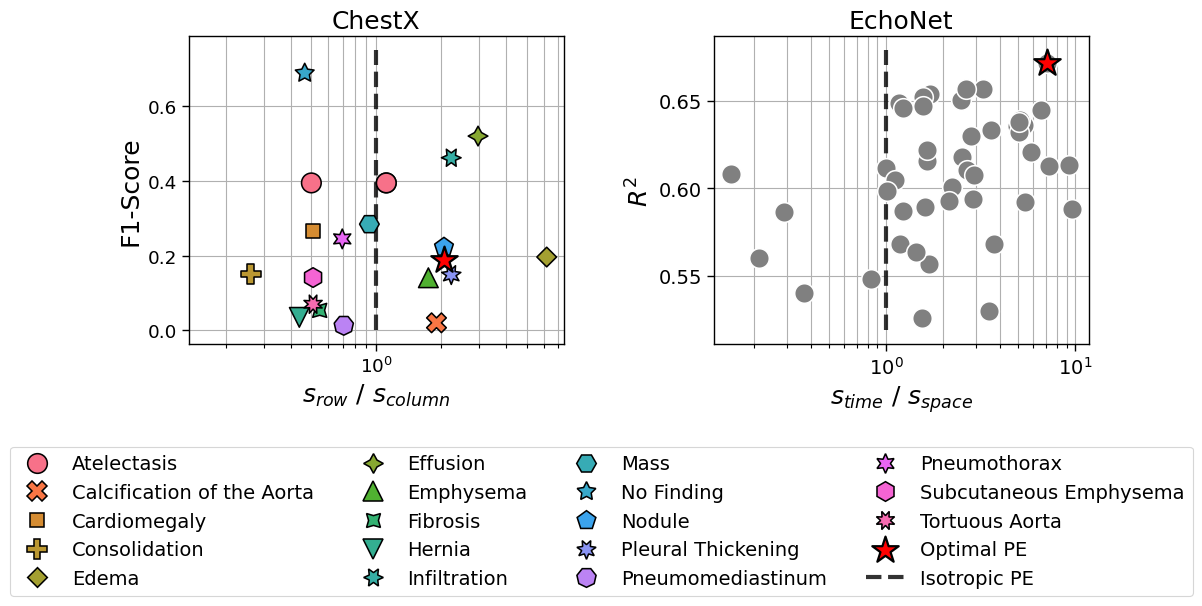

In [7]:
# Define font sizes
fontsize = 18
labelsize = 14

# Define highlight point style
best_point_kwargs = dict(
    color="red", edgecolor="black", s=400, marker="*", label="Optimal PE", zorder=4
)

# Create figure and axes
fig, axs = plt.subplots(1, 2, figsize=(9, 4))

# Plot first scatter plot (ChestX)
sns.scatterplot(
    data=other_points,
    x="Isotropy", y="value", hue="class", style="class",
    ax=axs[0], s=200, edgecolor="black", zorder=3
)
sns.scatterplot(data=mean_point, x="Isotropy", y="value", ax=axs[0], **best_point_kwargs)

# Formatting first plot
axs[0].set_title("ChestX", fontsize=fontsize)
axs[0].set_xlabel(r"$s_{row}$ / $s_{column}$", fontsize=fontsize)
axs[0].set_ylabel("F1-Score", fontsize=fontsize)
axs[0].set_xscale("log")
axs[0].vlines(1, 0, 0.75, color="black", ls="--", lw=3, alpha=0.8, label="Isotropic PE", zorder=2)

# Set symmetric log limits around x=1
x_min, x_max = plot_df["Isotropy"].min(), plot_df["Isotropy"].max()
log_range = max(abs(np.log10(x_max)), abs(np.log10(x_min))) * 1.1
axs[0].set_xlim(10**-log_range, 10**log_range)

# Adjust legend and grid
axs[0].legend(loc="upper center", bbox_to_anchor=(1.1, -0.3), ncol=4, fontsize=labelsize, frameon=True)
axs[0].grid(which="both")

# Plot second scatter plot (EchoNet)
sns.scatterplot(data=spacetime_df, x="isotropy", y="r2", color="gray", ax=axs[1], s=200, zorder=3)
sns.scatterplot(spacetime_df.loc[[spacetime_df["r2"].idxmax()]], x="isotropy", y="r2", legend=False, **best_point_kwargs)

# Formatting second plot
ymin, ymax = axs[1].get_ylim()
axs[1].set_xscale("log")
axs[1].vlines(1, ymin, ymax, color="black", ls="--", lw=3, alpha=0.8, label="Isotropic PE", zorder=2)
axs[1].grid(which="both")
axs[1].set_ylabel("$R^2$", fontsize=fontsize)
axs[1].set_xlabel("$s_{time}$ / $s_{space}$", fontsize=fontsize)
axs[1].tick_params(axis='both', labelsize=labelsize)
axs[1].set_title("EchoNet", fontsize=fontsize)

# Show plot
fig.subplots_adjust(left=0, right=1, wspace=0.4)  # Adjust horizontal spacing
plt.savefig("../results/optimal_afpe.eps", dpi=300, bbox_inches="tight")
plt.show()